# Convergent Cross Mapping On the Fisheries Game
This notebook demonstrates the use of Convergent Cross Mapping (CCM) on the Fisheries Game, a dynamic predator-prey system. To conduct CCM, we'll use the causal_ccm Python package by Prince Joseph Erneszer Javier, which you can find [here](https://github.com/PrinceJavier/causal_ccm). This demo follows the basic procedure used in the tutorial for the causal_ccm pakage, which you can find [here](https://github.com/PrinceJavier/causal_ccm/blob/main/usage_sample.ipynb).

## Convergent Cross Mapping
CCM is a technique for understanding causality in dynamical systems where the effects of causal variables cannot be separated or uncoupled from the variables they influence (Sugihara et al., 2012). [Rohini wrote a great blog post about CCM in 2021](https://waterprogramming.wordpress.com/2021/03/12/introduction-to-convergent-cross-mapping/), so I'll just provide a quick summary here and refer readers to Rohini's post for more details.

CCM harnesses the idea that the dynamics of a system can be represented by an underlying manifold, which can be approximated using lagged information from time series of each variable of interest. If variable X has a causal effect on variable Y, then information about X should be encoded in variable Y, and we can "recover" historical states of X from the historical time series of Y. Using this concept, CCM develops "shadow manifolds" for system variables, and examines the relationships between shadow manifolds using cross mapping, which (to dramatically oversimplify) involves sampling nearest-neighbor points in one manifold, and determining if they correspond to neighboring points in the other. For a more detailed explanation of CCM, I highly recommend reading Sugihara et al., 2012. I also found the series of videos created by the authors to be extremely helpful, you can find them [here](https://www.youtube.com/playlist?list=PL-SSmlAMhY3bnogGTe2tf7hpWpl508pZZ).


## Simulating the predator-prey system
We'll start by simulating the predator prey system used in [Hadjimichael et al., (2020)](https://www.hindawi.com/journals/complexity/2020/4170453/). This system models the population dynamics of two species, a predator and a prey. The simulation uses two differential equations to model the dynamics of the predator-prey system:

$$\frac{dx}{dt} = bx(1-\frac{x}{K}) - \frac{\alpha x y}{y^{m }+ \alpha h x} - zx$$

$$\frac{dy}{dt} = \frac{c \alpha x y}{\alpha h x} -dy$$

Where x and y represent the prey and predator population densities, t represents the time in years, a is the prey availability, b is the prey growth rate, c is the rate at which prey is converted to new predators, d is the predator death rate, h is the time needed to consume prey (called the handling time), K is the carrying capacity for prey, m is the level of predator interaction and z is the harvesting rate. In the cell below, we'll simulate this system for a given set of environmental parameters (a, b etc.), and plot the dynamics over 120 time periods. For more details on the Fisheries system, see the training blog posts by Lillian and Trevor ([part 0](https://waterprogramming.wordpress.com/2022/07/11/__trashed-3/), [part 1](https://waterprogramming.wordpress.com/2022/08/08/fisheries-training-part-1-harvest-optimization-and-moea-diagnostics/), [part 2](https://waterprogramming.wordpress.com/2022/09/14/fisheries-training-part-2-tradeoff-visualization-and-introduction-to-j3/)).

Text(0.5, 1.0, 'Population Dynamics')

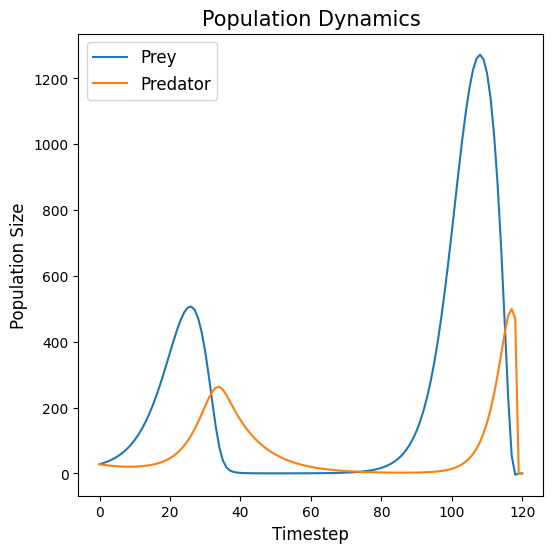

In [128]:
import numpy as np
from matplotlib import pyplot as plt
# assign default parameters
tsteps = 120 # number of timesteps to simulate
a = 0.01 # prey availability
b = 0.25 # prey growth rate
c = 0.30 # rate that prey is converted to predator
d = 0.1 # predator death rate
h = 0.61 # handling time
K = 1900 # prey carrying capacity
m = .20 # predator interference rate

# create arrays to store predator and prey populations
prey = np.zeros(tsteps+1)
pred = np.zeros(tsteps+1)

# initial population levels
prey[0] = 28
pred[0] = 28

# harvesting, which we will keep at 0 for this example
z = np.zeros(len(prey))

# simulate the system
for t in range(tsteps):
    if prey[t] > 0 and pred[t] > 0:
        prey[t + 1] = (prey[t] + b * prey[t] * (1 - prey[t] / K) - (a * prey[t] * pred[t]) / (np.power(pred[t], m) +
                                                            a * h * prey[t]) - z[t] * prey[t])   # Prey growth equation
        pred[t + 1] = (pred[t] + c * a * prey[t] * pred[t] / (np.power(pred[t], m) + a * h *
                                                            prey[t]) - d * pred[t]) # Predator growth equation

# plot the polulation dynamics
fig = plt.figure(figsize=(6,6))
plt.plot(np.arange(tsteps+1), prey, label = 'Prey')
plt.plot(np.arange(tsteps+1), pred, label = 'Predator')
plt.legend(prop={'size': 12})
plt.xlabel('Timestep', size=12)
plt.ylabel('Population Size', size=12)
plt.title('Population Dynamics', size=15)


With these parameters, we can visualize the trajectory and direction field of the system of equations, which is shown below (I'm not including ploting code here for brevity, but see [this tutorial](https://waterprogramming.wordpress.com/2018/02/12/plotting-trajectories-and-direction-fields-for-a-system-of-odes-in-python/) if you're interested in making these plots). In CCM terms, this is a visualization of the underlying manifold of the dynamical system.

![trajectories](trajectories.png)

## Causal detection with CCM
From the system of equations above, we know there is a causal relationship between the predator and the prey and the two variables do indeed lie on a common manifold. Below, we'll test whether CCM can detect this relationship, if the algorithm works as it should, we will see a clear indication that the two populations are causally linked.

To conduct CCM, we need to specify the number of dimensions to use for shadow manifolds, E, the lag time, tau, and the library size, L.

The first term in CCM is convergent, because the algorithm should converge to a stable approximation of causality as the library size increases. Below we'll test library sizes from 10 to 100 to see if we achieve convergence for the Fisheries system. We'll start by assuming shadow manifolds have two dimensions (E=2), and a lag time of one time step (tau=1). To test convergence, we'll plot the correlation (rho) between the shadow manifold predictions and the historical states of the two variables.

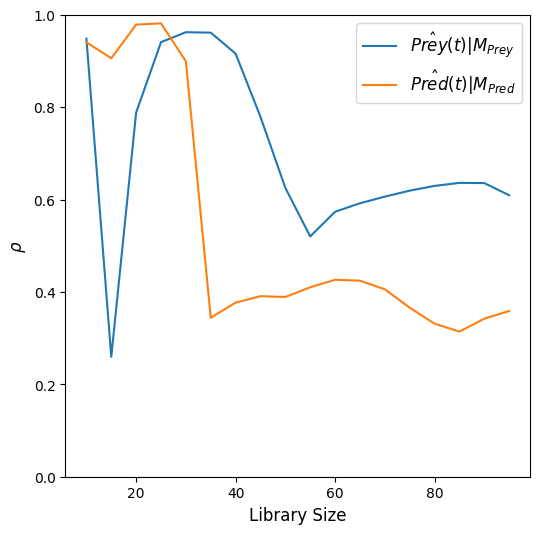

In [150]:
from causal_ccm.causal_ccm import ccm
E = 2 # dimensions of the shadow manifold
tau = 1 # lag time
L_range = range(10, 100, 5) # test a range of library sizes
preyhat_Mpred, predhat_Mprey = [], [] # correlation list
for L in L_range:
    ccm_prey_pred = ccm(prey, pred, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_pred_prey = ccm(pred, prey, tau, E, L) # define new ccm object # Testing for Y -> X
    preyhat_Mpred.append(ccm_prey_pred.causality()[0])
    predhat_Mprey.append(ccm_pred_prey.causality()[0])

# Plot Cross Mapping Convergence
plt.figure(figsize=(6,6))
plt.plot(L_range, preyhat_Mpred, label='$\hat{Prey}(t)|M_{Prey}$')
plt.plot(L_range, predhat_Mprey, label='$\hat{Pred}(t)|M_{Pred}$')
plt.ylim([0,1])
plt.xlabel('Library Size', size=12)
plt.ylabel(r'$\rho$', size=12)
plt.legend(prop={'size': 12})

In the figure above, we see that CCM does seem to detect a causal relationship between the predator and prey and the estimate of the strength of this relationship starts to stablize (converge) with a library size of around 60.

Next, we'll examine how our lag time (tau) used to construct the shadow manifolds impacts our findings.

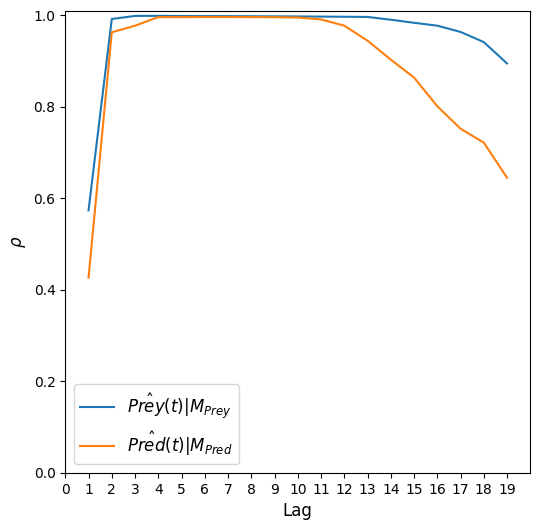

In [151]:
from causal_ccm.causal_ccm import ccm
E = 2 # dimensions of the shadow manifold
L = 60 # length of library (we'll return to this later)

# first, test different lags for construction of the shadow manifolds
# we'll test lags from 0 to 30 time steps
preyhat_Mpred, predhat_Mprey = [], []  # lists to store correlation
for tau in range(1, 20):
    ccm_prey_pred = ccm(prey, pred, tau, E, L)  # define new ccm object # Testing for prey -> pred
    ccm_pred_prey = ccm(pred, prey, tau, E, L)  # define new ccm object # Testing for pred -> prey
    preyhat_Mpred.append(ccm_prey_pred.causality()[0]) # stores prey -> pred
    predhat_Mprey.append(ccm_pred_prey.causality()[0]) # stores pred -> prey

# plot the correlation for different lag times
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,20), preyhat_Mpred, label='$\hat{Prey}(t)|M_{Prey}$')
plt.plot(np.arange(1,20), predhat_Mprey, label='$\hat{Pred}(t)|M_{Pred}$')
plt.ylim([0,1.01])
plt.xlim([0,20])
plt.xticks(np.arange(20))
plt.xlabel('Lag', size=12)
plt.ylabel(r'$\rho$', size=12)
plt.legend(prop={'size': 12})

The results shown above indicate that a lag time of 1 (which we initially assumed) does not adequately capture the causal relationship between the two variables. When lag times are set between 5 and 10, CMM shows a much stronger relationship between the two variables. Using this infomation, we can again test the convergence across different library sizes.

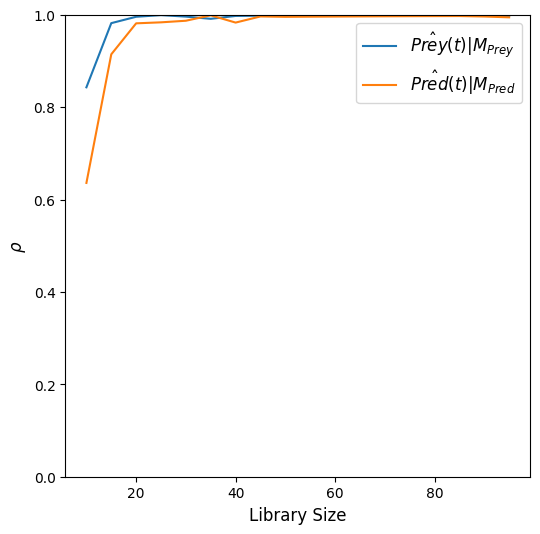

In [143]:
E = 2 # dimensions of the shadow manifold
tau = 5
L_range = range(10, 100, 5)
preyhat_Mpred, predhat_Mprey = [], [] # correlation list
for L in L_range:
    ccm_prey_pred = ccm(prey, pred, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_pred_prey = ccm(pred, prey, tau, E, L) # define new ccm object # Testing for Y -> X
    preyhat_Mpred.append(ccm_prey_pred.causality()[0])
    predhat_Mprey.append(ccm_pred_prey.causality()[0])

# Plot Cross Mapping Convergence
plt.figure(figsize=(6,6))
plt.plot(L_range, preyhat_Mpred, label='$\hat{Prey}(t)|M_{Prey}$')
plt.plot(L_range, predhat_Mprey, label='$\hat{Pred}(t)|M_{Pred}$')
plt.ylim([0,1])
plt.xlabel('Library Size', size=12)
plt.ylabel(r'$\rho$', size=12)
plt.legend(prop={'size': 12})

In the plot above, we observe that CCM with a lag size of 5 converges much faster, and generates stronger correlation than our original estimate using tau = 1. In fact, CCM reconstruction can reconstruct the historical system states almost perfectly. To see why, we can visualize the underlying shadow manifolds and cross mapping conducted for this analysis (this is conveniently available in the causal_ccm package with the visualize_cross_mapping function).

prey -> predator: 0.9983770271380581


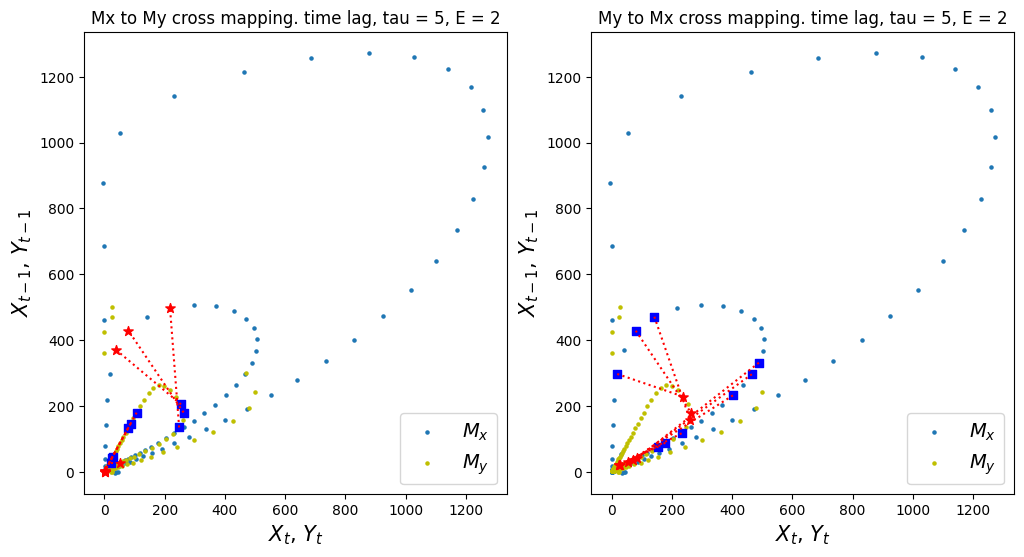

In [161]:
# set lag (tau) to 7 and examine results
tau = 5

# prey -> predator
ccm1 = ccm(prey,pred, tau, E, L) # prey -> predator
print("prey -> predator: " + str(ccm1.causality()[0]))

# visualize the cross mapping from the two shadow manifolds
ccm1.visualize_cross_mapping()

The plots above show the two shadow manifolds for prey (X in these plots) and predator (Y in these plots). Blue boxes represent points sampled from one manifold, and red stars indicate the location of those points when mapped to the other shadow manifold. We observe that the shapes of the shadow manifolds preserve the general characteristics of the original manifold, shown with the trajectories plotted above (just before the CCM analysis). We can also use the causal_ccm package to visualize the correlation between the prey and the CCM prey estimates.

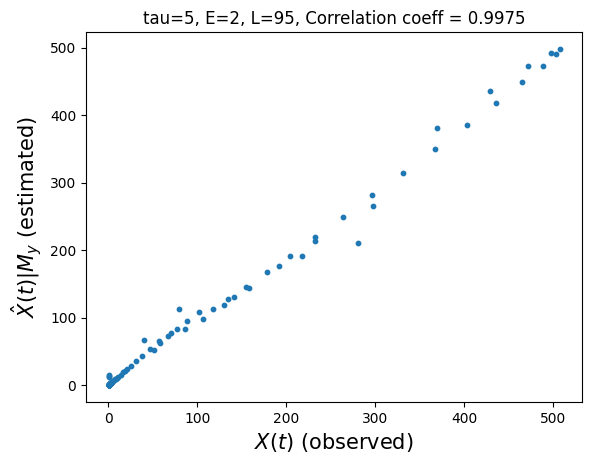

In [145]:
# Visualize the resulting correlation between sampled points and observed points
ccm1.plot_ccm_correls()

We can conduct the same exercise with the predator population (note that below X is now predators because the python package automatically calls the variable that you are testing X).

In [146]:
# predator -> prey
ccm2 = ccm(pred,prey, tau, E, L) # predator -> prey
print("predator -> prey: " +  str(ccm2.causality()[0]))

predator -> prey: 0.9943433312709615


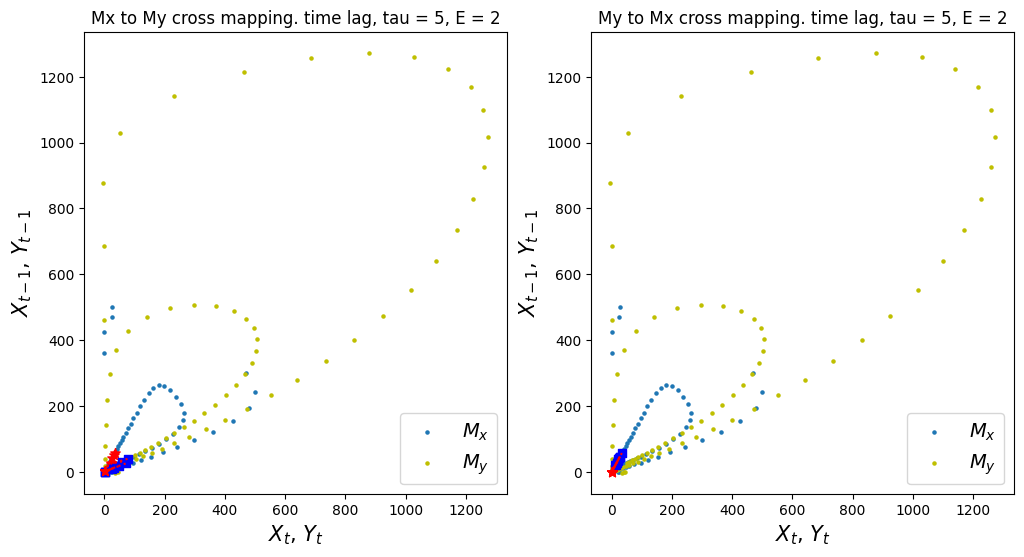

In [148]:
# visualize shadow manifolds
ccm2.visualize_cross_mapping()

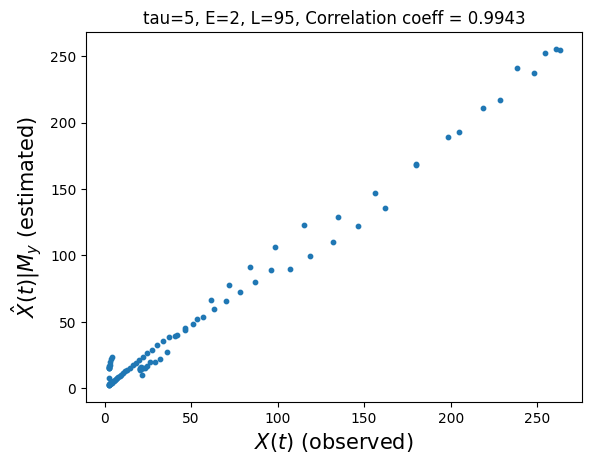

In [149]:
# plot correlation
ccm2.plot_ccm_correls()

## Concluding thoughts
This example demonstrates that CCM indeed can detect the causal relationship between predator and prey in this system. This shouldn't come as a suprise, since we knew from the start that a strong causal relationship does exist within this system. Still, I find it almost unnerving how well a job CCM manages to do here. For more info on CCM and coding CCM, see the links below.


[A great tutorial of CCM by the author of the Python package](https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html#)

[Rohini's blog post](https://waterprogramming.wordpress.com/2021/03/12/introduction-to-convergent-cross-mapping/)

[Video links describing CCM](https://www.youtube.com/playlist?list=PL-SSmlAMhY3bnogGTe2tf7hpWpl508pZZ)
